# Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · September 2018 (actualizado en Julio 2025) · 5 min read

---

# Resumen

La detección de anomalías es un problema interesante de estudiar porque permite emitir alertas tempranas y realizar mantenimientos preventivos antes que las fallas se vuelvan catastróficas. Actualmente cada vez más autores utilizan la inteligencia artificial (AI, por sus siglas en inglés) con este propósito, pero también existen métodos computacionalmente más baratos y que requieren menos datos de entrenamiento, como la media móvil (MA, por sus siglas en Inglés), la cual tratamos en el presente notebook. Planteamos un ejemplo de monitoreo de tiempos de respuesta en un servidor web para explicar la MA e indicamos cómo elegir el número de vecinos de la ventana de análisis para evitar falsos positivos o retrasos en la emisión de las alertas.

# Historia
En septiembre del 2018 unos 156.965 contribuyentes en todo el país empezaron a emitir sus tiquetes de compra solamente de manera electrónica, empleando el sistema contruido por el Ministerio de Hacienda, el Banco Central de Costa Rica (BCCR) y la Empresas de Servicios Públicos de Heredia (ESPH). La expectativa de parte del comercio era que sus sistemas internos iban a recibir la aprobación inmediata de parte de Hacienda para los documentos generados, y por ello, al experimentar retrasos de hasta 47 segundos expresaron su preocupación en las redes sociales del gobierno. Algunos de los contribuyentes más informados hicieron uso del artículo 15º de la resolución Nº DGT-R-48-2016, que permitía emitir temporalmente las facturas en papel, para luego ingresarlas cuando el sistema estuviera arriba [4, 5]. 

![](../img/pexels-imin-technology-276315592-12935062.jpg)

Los equipos de desarrollo de las instituciones involucradas iniciaron una investigación, y determinaron que ciertamente había cierto retraso entre los componentes para la verificación de la firma digital, pero que ese retraso por debajo del tiempo máximo de respuesta de de tres horas, establecido por ley [4]. Actualmente los sistemas son más eficientes y la recepción de un tiquete electrónico tarda usualmente unos pocos minutos después de la compra.

# Analizando un ejemplo
Podemos simular un ejemplo de tiempos de respuesta usando un proceso normal de media $\mu=5$ y varianza $\sigma^2=900$ (en minutos) y agregar dos eventos que excedan el máximo de tres horas, en los instantes 25 a 85 y 200.

N=240


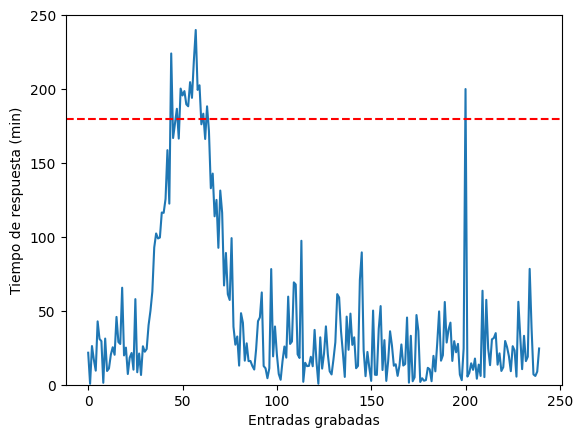

In [1]:
import matplotlib.pylab as plt
import numpy as np;

Ts = 5.0*60.0 # periodo de muestreo (en segundos)
D = 20*60.0*60.0 # duración de la señal (en segundos)
N = int(D/Ts)
print(f'N={N}')
mu, sigma = 5, 30
x = np.abs(np.random.normal(mu, sigma, N))

n0=25
x[n0:n0+60] += 180*np.hanning(60)
x[200] = 200

plt.figure()
plt.plot(x,'tab:blue')
plt.axhline(y=180, color='r', linestyle='--')
plt.ylim([0, 250])
plt.xlabel('Entradas grabadas')
plt.ylabel('Tiempo de respuesta (min)')
plt.show()

Como observamos en la figura anterior, los instantes 25 a 85 sobrepasan el límite de tres horas señalado con una línea roja, y ameritan la emisión de una alerta; sin embargo, el instante 200 es más bien un *evento transitorio* que puede ser ignorado ya que tiene amplitud baja y corta duración. Para ignorar este tipo de eventos transitorios (o frecuencias altas) se puede emplear un filtro de media móvil, una función normalmente disponible en software de monitoreo de sistemas, como New Relic o Graphene [7, 8].

# Media móvil
La media móvil -también llamada _integral con fuga_ o _leaky integrator_ (en inglés)- es un filtro pasabajas cuya ecuación se describe a continuación [2]:
$$
    y[n] = \frac{1}{M}\sum_{m=0}^{M}{x[n-m]}\quad (1),
$$
donde $M$ es la cantidad de vecinos de la ventana de análisis y el índice $n$ es la posición analizada en la señal (también llamada serie de tiempo). No se consideran los vecinos posteriores a la muestra actual, pues el procesamiento se realiza de manera causal, es decir, que no se pueden usar muestras que no han sido grabadas. 

Eligiendo arbitrariamente $M=20$ vecinos, la ecuación anterior permite obtener la siguiente version suavizada de la señal de ejemplo presentada en la sección anterior:

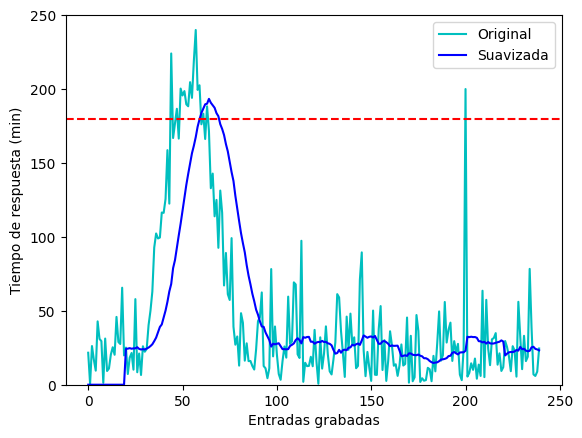

In [4]:
def graficar_seniales(x:np.ndarray, y:np.ndarray):
    plt.figure()
    plt.plot(x,'c',label='Original')
    plt.plot(y,'blue',label='Suavizada')
    plt.legend()
    plt.axhline(y=180, color='r', linestyle='--')
    plt.ylim([0, 250])
    plt.xlabel('Entradas grabadas')
    plt.ylabel('Tiempo de respuesta (min)')
    plt.show()

def ma(x:np.ndarray, M:int) -> np.ndarray:
    N = len(x)
    y = [0.0]*N
    for n in range(M,N):
        y[n] = np.sum(x[n-M:n])/M
    return y

graficar_seniales(x, ma(x, 20))

Donde se observa que el pico en 200 a sido eliminado y la anomalía en el rango 60 a 85 se conserva, como es deseado.

# Retraso temporal

Un problema del procesamiento anterior es que la señal suavizada está retrasada (o desplazada a la derecha) respecto de la señal original, esto se conoce como *retraso de grupo* y es determinado por el tamaño de la ventana de análisis. Una ventana pequeña produce un retraso de grupo corto (las alertas se generan rápidamente) pero también produce mayor número de falsos positivos; al contrario, una ventana de análisis grande brinda un mejor filtrado de las frecuencias altas pero produce un retraso de grupo largo (las alertas se generan de forma tardía). 

El retraso de grupo se puede expresar en terminos temporales multiplicando el periodo de muestreo $T_s$ por el tamaño de la ventana, es decir, $MT_s$ [2]. Con $M=20$ y un periodo de muestreo de $T_s=5$ minutos se obtiene un retraso de grupo de 100 minutos (1 hora y 40 minutos), mientras que con $M=3$ (figura de abajo) el retraso de grupo se reduce a 15 minutos. El retraso de grupo también puede reducirse aumentando el periodo de muestreo, pero esto significa generar más datos, lo que aumenta los gastos en almacenamiento en la nube. 

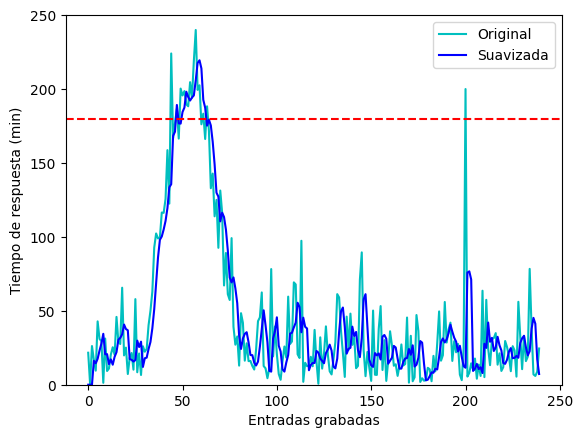

In [3]:
graficar_seniales(x, ma(x, 3))

Con una ventana de análisis más pequeña se observa que el procesamiento sigue siendo útil y que la señal suavizada esta menos desplazado respecto del fitrado anterior, aunque hay más frecuencias altas.

# Inteligencia artificial
Como se mencionó en el resumen actualmente cada vez más autores utilizan la inteligencia artificial para realizar detección de anomalías, aunque con métodos más costozos que la media móvil. Un ejemplo es el uso de encoders, que entrena el sistema usando grandes volúmenes de datos del sistema cuando está estable (a partir de algunas entradas del sistema) para luego calcular el error mínimo cuadrado (MSE, por su siglas en Inglés) entre la señal real y la señal simulada y emitir una alerta cuando el MSE se excede más allá de un umbral establecido [6].

# Conclusiones
La media móvil puede ser empleada para la detección de anomalías de un sistema, para ello es necesario establecer un umbral máximo para la métrica elegida (tiempo de respuesta del servidor, en el ejemplo presentado) y un tamaño de ventana. El tamaño de la ventana determina el retraso de grupo de la media móvil, donde una ventana pequeña produce un retraso de grupo corto pero con un mayor número de falsos positivos, mientras que una ventana de análisis grande brinda un mejor filtrado pero produce un retraso de grupo largo (las alertas se generan de forma tardía). Como trabajo futuro se propone investigar si hay forma de calcular un número de vecinos óptimo dados algunos estadísticos de la señal, sin entrar en un ptener que incurrir en un proceso de prueba y error; y si el uso de filtros adaptativos puede aportar alguna ventaja.

# Referencias
1. Brian Jackson. How to Effectively Monitor and Scale for Website Traffic. KeyCDN. 10 de enero de 2017. URL: https://www.keycdn.com/blog/scale-website-traffic/ (última vez consultado el 16 de setiembre de 2018)
2. John G. Proakis y Dimitris K. Manolakis. Digital Signal Processing (4 edición). Prentice-Hall, Inc., Upper Saddle River, NJ, USA. 2006
3. Derek Kraan. Why is my site slow if New Relic says it's fast? Request Queueing. URL: https://img.springe.st/2013_11_26_10_40_22_zdspb.jpg (última vez consultado el 20 de setiembre de 2018)
4. Carlos Cordero. Sistema de factura electrónica falló el día que recibía a nuevo grupo de contribuyentes. La República, tecnología. URL: https://www.elfinancierocr.com/tecnologia/sistema-de-factura-electronica-fallo-el-dia-que/OQ42RGIS2NFPHD2UDAGI66KNQM/story/ (última vez consultado el 23 de setiembre de 2018)
5. Ministerio de Hacienda, Dirección General de Tributación. Comprobantes electrónicos, resolución Nº DGT-R-48-2016. Gobierno de Costa Rica. URL: https://tribunet.hacienda.go.cr/docs/esquemas/2016/v4/Resolucion%20Comprobantes%20Electronicos%20%20DGT-R-48-2016.pdf (última vez consultado el 24 de setiembre de 2018)
6. Brian Douglas. Introduction to Anomaly Detection for Engineers. Mathworks. URL: https://www.mathworks.com/videos/introduction-to-anomaly-detection-for-engineers-1663930223584.html (consultado por última vez el 1 de Julio del 2025).
7. New Relic. Use sliding windows for smoother charts. URL: https://docs.newrelic.com/docs/nrql/using-nrql/create-smoother-charts-sliding-windows/ (consultado por última vez el 5 de Julio del 2025).
8. Graphite. Functions. URL: https://graphite.readthedocs.io/en/latest/functions.html#graphite.render.functions.movingAverage (consultado por última vez el 5 de Julio del 2025).

# Creditos de la imagen
* iMin Technology. https://www.pexels.com/photo/a-close-up-shot-of-a-person-holding-a-payment-terminal-12935062/ (image free to use).

---
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="licencia Creative Commons" style="border-width:0" src="../img/80x15.png" /></a><p style="text-align: center;"> Esta obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">licencia Creative Commons Atribución 4.0 Internacional</a>. El sitio <a href="https://juanfonsecasolis.github.io/">juanfonsecasolis.github.io</a> es un blog costarricence dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar la fuente puede usar Bibtex:</p>
```
@online{Fonseca2018,
  author = {Juan M. Fonseca-Solís},
  title = {Media móvil para la emisión de alertas tempranas: el día en el que falló el sistema de facturación electrónica en Costa Rica},
  year = 2018,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html},
  urldate = {}
}
```

<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
*/
var disqus_config = function () {
this.page.url = 'https://juanfonsecasolis.github.io/blog/JFonseca.suavizadoTraficoServidorWeb.html';  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = 2; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};

(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://https-juanfonsecasolis-github-io.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
<script id="dsq-count-scr" src="//https-juanfonsecasolis-github-io.disqus.com/count.js" async></script>